In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

<h1> Research Questions </h1>

In [3]:
def get_comparison_summary(parameter):
    return pd.concat([pomodoro[parameter].describe(),exman[parameter].describe()],axis=1,keys=["pomodoro","exman"])

In [4]:
def normalize_data(data_input, normalizer, data_output, df):
    df[data_output] = df[data_input]/df[normalizer]*60

In [5]:
def create_focusDF(data,filenr):
    
    percentage_goals = []
    goals_achieved = []
    goals_set = []
    broken_Focus = []
    brokenFocus_number = []
    distraction_count = []
    distraction_time = []
    nr_of_services = []
    messages_received_in_focus = []
    focus_ids = []
    nr_of_autoreplies_per_focus = []
    
    # transform json part to pandas dataframe
    df = pd.json_normalize(data["focusSessions"])
    
    # create new column, which calculates how long a user stayed in focus
    df["minutesInFocus"] = round((df["endTime"] - df["startTime"])/60000,2)
    
    #df["distractionCount"] = 0

    
    for index, row in df.iterrows():
        # calculate percentage of achieved goals
        if len(row['goals']) == 0:
            percentage_goals.append(0)
            goals_set.append(0)
            goals_achieved.append(0)
        else:
            percentage_goals.append(round(len(row['completedGoals'])/len(row['goals']),2))
            goals_set.append(len(row['goals']))
            goals_achieved.append(len(row['completedGoals']))
        
        # calculate broken focus length
        if len(row["brokenFocus"]) == 0:
            broken_Focus.append(0)
            brokenFocus_number.append(0)
        else:
            break_per_focus= 0
            nr_of_breaks = 0
            for element in row["brokenFocus"]:
                if len(element) ==2:
                    break_per_focus += ((element[1]-element[0])/60000)
                    nr_of_breaks +=1
            broken_Focus.append(round(break_per_focus,2))
            brokenFocus_number.append(nr_of_breaks)
            
        # get distractionCount
        if len(row["activeWindows"]) == 0:
            distraction_count.append(0)
            distraction_time.append(0)
        else:
            distractionCountPerFocus = 0
            distractionTime = 0
            for index, element in enumerate(row["activeWindows"]):
                if element["isDistraction"]:
                    distractionCountPerFocus += 1
                    if index < len(row["activeWindows"])-1:
                        #print(index, len(row["activeWindows"]))
                        duration = row["activeWindows"][index+1]["timestamp"] - element["timestamp"]
                    else:
                        #print(row["endTime"])
                        duration = row["endTime"] - element["timestamp"]
                    distractionTime += (duration/60000)
            distraction_count.append(distractionCountPerFocus)
            distraction_time.append(distractionTime)
        
        # get number of used services
        nr_of_services.append(len(row["services"]))
        
        messages_received = 0
        autoreplies = 0
        for element in row["services"]:
            # get number of received messages
            messages_received += len(element["messages"])
            autoreplies += len(element["autoReplied"])
            
        messages_received_in_focus.append(messages_received)
        nr_of_autoreplies_per_focus.append(autoreplies)
        focus_ids.append(row["id"])
        
            
    df["focusID"] = focus_ids
    df["PSNR"] = filenr[:3]
    df["distractionCount"] = distraction_count
    df["distractionTime"] = distraction_time
    df["numberOfServices"] = nr_of_services
    df["messages_received_in_focus"] = messages_received_in_focus 
    df["brokenFocus"] = broken_Focus
    df["nrOfBreaks"] = brokenFocus_number    
    df["percentageCompletedGoals"] = percentage_goals
    df["goalsAchieved"] = goals_achieved
    df["goalsSet"] = goals_set
    df["autoReplied"] = nr_of_autoreplies_per_focus
    
    
    # focus session which were longer than 6 hours were dropped (2 datapoints, probably participant forgot to close 
    # focus session)
    df = df[(df["minutesInFocus"] < 300) & (df['minutesInFocus']>10)]
    
    # drop columns startTime, endTime, originalEndTime, goals and completedGoals
    df = df.drop(["id","services","calendarSubject",'startTime', 'endTime','originalEndTime','goals','completedGoals',"activeWindows","comments"], axis=1)
    return df

In [6]:
from os import listdir
from os.path import isfile, join

mypath = "./data"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

df = pd.DataFrame()

for i in onlyfiles:
    with open(f'data/{i}', 'r') as outfile:
        data = json.load(outfile)
        df_temp = create_focusDF(data,i)
        df = pd.concat([df,df_temp])
        

df = df.reset_index()

In [7]:
df

,index,brokenFocus,rating,scheduled,appVersion,minutesInFocus,focusID,PSNR,distractionCount,distractionTime,numberOfServices,messages_received_in_focus,nrOfBreaks,percentageCompletedGoals,goalsAchieved,goalsSet,autoReplied
0,5,1.77,4,False,exman,40.00,2d7bd4d9-e880-4ea9-9bde-a3ae1ce6b4ec,p06,0,0.000000,4,1,1,1.0,1,1,0
1,6,6.33,2,False,exman,40.00,df1eabfa-1aa7-48eb-8bad-0c4b34931335,p06,0,0.000000,4,12,1,0.0,0,1,0
2,7,6.59,5,False,exman,52.28,66b0c95e-d104-40b6-8220-f428b01a0063,p06,0,0.000000,4,3,1,0.0,0,0,0
3,8,0.00,5,False,exman,40.00,cf49b310-4671-41f1-a398-738010502b6c,p06,0,0.000000,4,2,0,1.0,1,1,0
4,9,0.00,7,False,exman,40.00,cf56ab7e-a777-413c-979b-4580e6b2ce69,p06,0,0.000000,4,0,0,1.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,13,0.00,7,False,exman,25.00,a377cbf9-3813-4b4e-92d4-e89581a77f57,p10,13,1.901033,3,2,0,1.0,3,3,1
223,14,0.00,6,False,exman,25.00,9fddaa68-27bb-4f3c-a735-c28b9cb40c6a,p10,0,0.000000,3,0,0,1.0,1,1,0
224,15,0.00,7,False,pomodoro,15.41,ad13d661-9f00-423f-a897-e637d778e7a7,p10,1,0.400100,3,0,0,1.0,1,1,0
225,16,14.76,6,False,pomodoro,15.00,652e7ff6-70d4-4082-ae90-9b4ae8ded761,p10,7,14.592567,3,0,1,1.0,1,1,0


<h2>What is the effect of notification blocking and distraction discouragements during a user defined time period on their perceived productivity?</h2>


In [8]:
pomodoro = df[(df['appVersion'] == "pomodoro")]
exman = df[(df['appVersion'] == "exman")]

In [9]:
pomodoro

,index,brokenFocus,rating,scheduled,appVersion,minutesInFocus,focusID,PSNR,distractionCount,distractionTime,numberOfServices,messages_received_in_focus,nrOfBreaks,percentageCompletedGoals,goalsAchieved,goalsSet,autoReplied
7,12,21.61,2,False,pomodoro,40.00,dbdaaf2b-aa10-4db9-9e32-30489174adf2,p06,0,0.000000,4,3,1,1.0,1,1,0
8,13,39.10,3,False,pomodoro,40.00,f3b3f7e7-d99f-4a05-aa48-121acf63153d,p06,0,0.000000,4,2,1,1.0,1,1,0
9,14,39.73,4,False,pomodoro,40.00,9504e872-a0eb-45da-8963-0cb59f923dc5,p06,0,0.000000,4,0,1,0.0,0,0,0
10,15,0.00,3,False,pomodoro,40.00,175cf3e1-fe58-4142-9e5b-adb15bae2e49,p06,0,0.000000,4,0,0,0.0,0,0,0
11,16,1.74,5,False,pomodoro,15.00,3bc42f29-d898-4989-bda5-df198a0eb99c,p06,0,0.000000,4,0,1,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,4,0.00,7,False,pomodoro,40.00,9aa68389-745d-4bcf-b59e-0cadd760b07f,p11,3,0.367667,2,0,0,0.0,0,0,0
208,5,0.19,None,False,pomodoro,40.00,de162c05-0876-440d-8203-d7bc92b92d91,p11,1,0.067117,2,4,1,0.0,0,0,0
224,15,0.00,7,False,pomodoro,15.41,ad13d661-9f00-423f-a897-e637d778e7a7,p10,1,0.400100,3,0,0,1.0,1,1,0
225,16,14.76,6,False,pomodoro,15.00,652e7ff6-70d4-4082-ae90-9b4ae8ded761,p10,7,14.592567,3,0,1,1.0,1,1,0


In [10]:
exman

,index,brokenFocus,rating,scheduled,appVersion,minutesInFocus,focusID,PSNR,distractionCount,distractionTime,numberOfServices,messages_received_in_focus,nrOfBreaks,percentageCompletedGoals,goalsAchieved,goalsSet,autoReplied
0,5,1.77,4,False,exman,40.00,2d7bd4d9-e880-4ea9-9bde-a3ae1ce6b4ec,p06,0,0.000000,4,1,1,1.00,1,1,0
1,6,6.33,2,False,exman,40.00,df1eabfa-1aa7-48eb-8bad-0c4b34931335,p06,0,0.000000,4,12,1,0.00,0,1,0
2,7,6.59,5,False,exman,52.28,66b0c95e-d104-40b6-8220-f428b01a0063,p06,0,0.000000,4,3,1,0.00,0,0,0
3,8,0.00,5,False,exman,40.00,cf49b310-4671-41f1-a398-738010502b6c,p06,0,0.000000,4,2,0,1.00,1,1,0
4,9,0.00,7,False,exman,40.00,cf56ab7e-a777-413c-979b-4580e6b2ce69,p06,0,0.000000,4,0,0,1.00,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,10,0.00,6,False,exman,25.00,0efb00b5-1378-4533-93c3-519f87e9074c,p10,0,0.000000,3,0,0,1.00,1,1,0
220,11,2.04,None,False,exman,25.00,8d1a45c2-4db1-48b2-af0c-ccd0d5aea3d0,p10,3,4.106250,3,7,1,0.00,0,2,2
221,12,0.00,6,False,exman,25.00,25706d86-3e0e-48ca-855b-d66429f948d2,p10,8,3.136850,3,0,0,0.25,1,4,0
222,13,0.00,7,False,exman,25.00,a377cbf9-3813-4b4e-92d4-e89581a77f57,p10,13,1.901033,3,2,0,1.00,3,3,1


<h4>goals achieved</h4>

In [11]:
normalize_data("goalsAchieved","minutesInFocus","goalsAchievedPerHour", exman)
normalize_data("goalsAchieved","minutesInFocus","goalsAchievedPerHour", pomodoro)

In [12]:
exman["goalsAchievedPerHour"].mean()

1.833449752093778

In [13]:
pomodoro["goalsAchievedPerHour"].mean()

1.3436390497595048

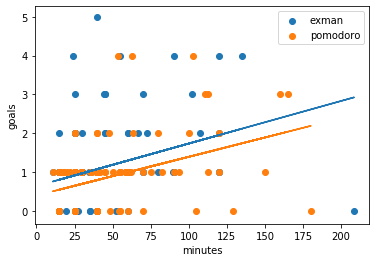

In [14]:
plt.scatter(exman["minutesInFocus"],exman["goalsAchieved"],label="exman")
plt.scatter(pomodoro["minutesInFocus"],pomodoro["goalsAchieved"], label="pomodoro")
plt.legend()

slope, intercept, r, p, stderr = scipy.stats.linregress(exman["minutesInFocus"], exman["goalsAchieved"])
plt.plot(exman["minutesInFocus"], intercept + slope * exman["minutesInFocus"])

slope, intercept, r, p, stderr = scipy.stats.linregress(pomodoro["minutesInFocus"], pomodoro["goalsAchieved"])
plt.plot(pomodoro["minutesInFocus"], intercept + slope * pomodoro["minutesInFocus"])

plt.xlabel("minutes")
plt.ylabel("goals")

plt.show()

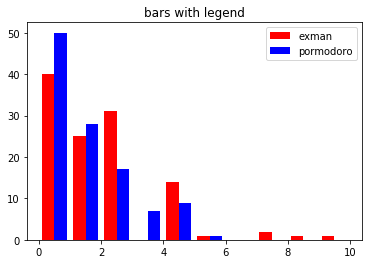

In [15]:
x = [list(exman["goalsAchievedPerHour"]),list(pomodoro["goalsAchievedPerHour"])]

label = ["exman","pormodoro"]
colors = ['red', 'blue']
plt.hist(x, histtype='bar', color=colors, label=label)
plt.legend(prop={'size': 10})
plt.title('bars with legend')


plt.show()

In [16]:
exman[["PSNR", "goalsAchieved", "goalsAchievedPerHour", "percentageCompletedGoals", "minutesInFocus"]].sort_values("goalsAchievedPerHour").tail(20)

,PSNR,goalsAchieved,goalsAchievedPerHour,percentageCompletedGoals,minutesInFocus
87,p07,2,2.666667,1.00,45.00
189,p08,1,4.000000,1.00,15.00
213,p10,1,4.000000,0.50,15.00
212,p10,3,4.000000,1.00,45.00
137,p01,3,4.000000,0.75,45.00
138,p01,1,4.000000,1.00,15.00
37,p12,1,4.000000,1.00,15.00
94,p07,2,4.000000,1.00,30.00
145,p01,1,4.000000,1.00,15.00
190,p08,1,4.000000,1.00,15.00


In [17]:
pomodoro[["PSNR", "goalsAchieved", "goalsAchievedPerHour", "percentageCompletedGoals", "minutesInFocus"]].sort_values("goalsAchievedPerHour").tail(20)

,PSNR,goalsAchieved,goalsAchievedPerHour,percentageCompletedGoals,minutesInFocus
167,p08,1,2.400000,1.0,25.00
71,p07,2,2.533249,1.0,47.37
82,p07,1,2.690583,1.0,22.30
67,p07,2,3.000000,1.0,40.00
155,p01,2,3.000000,1.0,40.00
128,p09,1,3.025719,1.0,19.83
12,p02,1,3.296703,1.0,18.20
73,p07,1,3.448276,1.0,17.40
79,p07,4,3.808315,1.0,63.02
224,p10,1,3.893576,1.0,15.41


In [55]:
print(exman[ "minutesInFocus"].mean())
print(pomodoro[ "minutesInFocus"].mean())

42.32973913043478
46.90749999999999


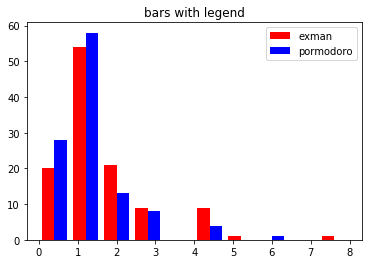

In [18]:
x = [list(exman["goalsSet"]),list(pomodoro["goalsSet"])]

label = ["exman","pormodoro"]
colors = ['red', 'blue']
plt.hist(x, histtype='bar', color=colors, label=label)
plt.legend(prop={'size': 10})
plt.title('bars with legend')


plt.show()

In [19]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["goalsAchievedPerHour"], pomodoro["goalsAchievedPerHour"], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.02587229862116291 T-Statistic:2.2438752466987286


The p-value is significant. Therefore, the user was more effective using our app exman than using the pomodoro timer.

<h4> Broken Focus per hour </h4>

In [20]:
normalize_data("brokenFocus","minutesInFocus","brokenFocusPerHour", exman)
normalize_data("brokenFocus","minutesInFocus","brokenFocusPerHour", pomodoro)

In [21]:
exman["brokenFocusPerHour"].mean()

0.4878479635410037

In [22]:
pomodoro["brokenFocusPerHour"].mean()

3.0109144450290617

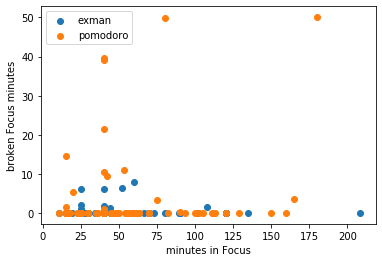

In [23]:
plt.scatter(exman["minutesInFocus"],exman["brokenFocus"],label="exman")
plt.scatter(pomodoro["minutesInFocus"],pomodoro["brokenFocus"], label="pomodoro")
plt.xlabel("minutes in Focus")
plt.ylabel("broken Focus minutes")
plt.legend()

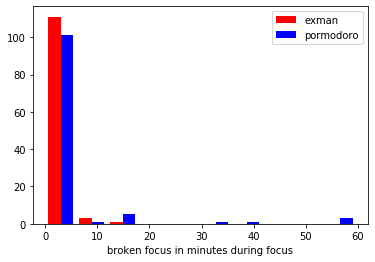

In [98]:
x = [list(exman["brokenFocusPerHour"]),list(pomodoro["brokenFocusPerHour"])]

label = ["exman","pormodoro"]
colors = ['red', 'blue']
plt.hist(x, histtype='bar', color=colors, label=label)
plt.legend(prop={'size': 10})

plt.xlabel("broken focus in minutes during focus")

plt.show()

In [110]:
exman[["PSNR", "focusID", "scheduled", "brokenFocus", "brokenFocusPerHour", "nrOfBreaks", "minutesInFocus"]].sort_values("brokenFocusPerHour").tail(10)

,PSNR,focusID,scheduled,brokenFocus,brokenFocusPerHour,nrOfBreaks,minutesInFocus
205,p11,719e4219-41c6-4750-a8e7-dd62e25080cb,False,0.84,1.260000,1,40.00
211,p10,9d3aeb48-8518-466f-9bd6-195159d83d9c,False,0.70,1.680000,1,25.00
215,p10,40335a80-5d91-4833-8b1c-5ed2dfac9a6d,False,1.27,1.731818,3,44.00
0,p06,2d7bd4d9-e880-4ea9-9bde-a3ae1ce6b4ec,False,1.77,2.655000,1,40.00
132,p01,ef98194e-2687-4985-bcdb-16c9d8937b2d,False,1.23,2.952000,1,25.00
220,p10,8d1a45c2-4db1-48b2-af0c-ccd0d5aea3d0,False,2.04,4.896000,1,25.00
2,p06,66b0c95e-d104-40b6-8220-f428b01a0063,False,6.59,7.563122,1,52.28
100,p07,c1c35f24-a35c-4d06-b137-be1a19e2c4f7,False,8.04,8.040000,1,60.00
1,p06,df1eabfa-1aa7-48eb-8bad-0c4b34931335,False,6.33,9.495000,1,40.00
216,p10,e1a2ecc5-90b8-461e-8749-80f098b39a8a,False,6.11,14.664000,2,25.00


In [111]:
pomodoro[["PSNR", "focusID", "scheduled", "brokenFocus", "brokenFocusPerHour", "nrOfBreaks", "minutesInFocus"]].sort_values("brokenFocusPerHour").tail(20)

,PSNR,focusID,scheduled,brokenFocus,brokenFocusPerHour,nrOfBreaks,minutesInFocus
64,p07,748af868-9737-454c-b4b5-8eb3721963b9,False,0.00,0.000000,0,55.00
71,p07,b6d3263a-a076-4d33-89d8-580fe8e76e16,False,0.00,0.000000,0,47.37
68,p07,c55bfc7b-9341-46e9-a058-6032efffa1d7,False,0.36,0.240000,1,90.00
208,p11,de162c05-0876-440d-8203-d7bc92b92d91,False,0.19,0.285000,1,40.00
12,p02,279e8657-e394-48da-bb02-f84df29e4791,False,0.22,0.725275,1,18.20
20,p17,24b945f7-5136-4b3d-87e8-f48d80490ce9,False,3.77,1.370909,3,165.00
127,p09,cb060b11-61df-4165-a273-0e15c949206a,False,0.37,1.480000,1,15.00
129,p09,92ef0f2c-dd68-4e55-b82a-91c0e06daa6c,False,1.12,1.674975,1,40.12
124,p09,_60pjae1k8kr36b9g8cqjeb9k75136b9p6t244ba574s3e...,True,3.34,2.672000,1,75.00
11,p06,3bc42f29-d898-4989-bda5-df198a0eb99c,False,1.74,6.960000,1,15.00


In [107]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["brokenFocusPerHour"], pomodoro["brokenFocusPerHour"], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.01711207312732622 T-Statistic:-2.418464796263217


In [117]:
print(exman["brokenFocusPerHour"].mean())
print(pomodoro[pomodoro["brokenFocusPerHour"] < 16.5]['brokenFocusPerHour'].mean())


0.4878479635410037
0.6920589733640399


In [118]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["brokenFocusPerHour"], pomodoro[pomodoro["brokenFocusPerHour"] < 16.5]['brokenFocusPerHour'], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.5416061038154044 T-Statistic:-0.611520264461177


In [92]:
print(exman[exman["brokenFocus"] == 0]['brokenFocus'].count() / exman["brokenFocus"].count())
print(pomodoro[pomodoro["brokenFocus"] == 0]['brokenFocus'].count() / pomodoro["brokenFocus"].count())

0.8956521739130435
0.8392857142857143


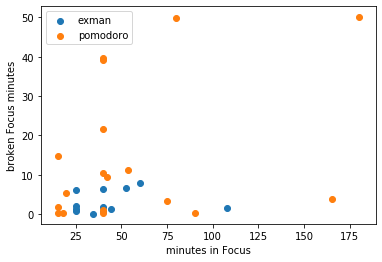

In [94]:
plt.scatter(exman[exman["brokenFocus"] != 0]['minutesInFocus'],exman[exman["brokenFocus"] != 0]['brokenFocus'],label="exman")
plt.scatter(pomodoro[pomodoro["brokenFocus"] != 0]['minutesInFocus'],pomodoro[pomodoro["brokenFocus"] != 0]['brokenFocus'], label="pomodoro")
plt.xlabel("minutes in Focus")
plt.ylabel("broken Focus minutes")
plt.legend()

<h4> broken focus frequency </h4>

In [25]:
normalize_data("nrOfBreaks","minutesInFocus","brokenFrequencyPerHour", exman)
normalize_data("nrOfBreaks","minutesInFocus","brokenFrequencyPerHour", pomodoro)

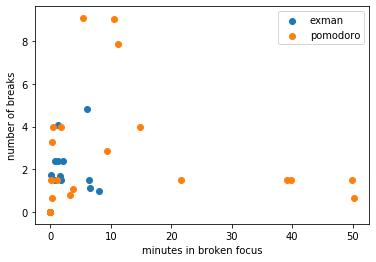

In [26]:
plt.scatter(exman["brokenFocus"],exman["brokenFrequencyPerHour"],label="exman")
plt.scatter(pomodoro["brokenFocus"],pomodoro["brokenFrequencyPerHour"], label="pomodoro")
plt.xlabel("minutes in broken focus")
plt.ylabel("number of breaks")
plt.legend()

In [27]:
exman["brokenFrequencyPerHour"].mean()

0.22747864168793977

In [28]:
pomodoro["brokenFrequencyPerHour"].mean()

0.5029443694609202

In [29]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["brokenFrequencyPerHour"], pomodoro["brokenFrequencyPerHour"], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.0992007025143192 T-Statistic:-1.6584728120491363


The effect on frequency of breaks is not significant, but the difference of the break duration between pomodoro and exman is significant on a 5% level. Reason for that not known yet.

<h4>distraction time </h4>

In [30]:
normalize_data("distractionTime","minutesInFocus","distractionTimePerHour",exman)
normalize_data("distractionTime","minutesInFocus","distractionTimePerHour",pomodoro)

In [31]:
exman["distractionTimePerHour"].mean()

1.733884165806526

In [32]:
pomodoro["distractionTimePerHour"].mean()

2.0561815823129317

In [33]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman["distractionTimePerHour"], pomodoro["distractionTimePerHour"], equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.7316975137945269 T-Statistic:-0.3433181976946759


Not significant

<h4>Summary page rating</h4>

In [34]:
exman["rating"].dropna().astype(int).mean()

5.885714285714286

In [35]:
pomodoro["rating"].dropna().astype(int).mean()

5.74

<h4> Productivity Rating </h4>

In [36]:
exman_rating = exman.dropna(subset=["rating"])
pomodoro_rating = pomodoro.dropna(subset=["rating"])

In [59]:
print(exman_rating['rating'].astype(int).mean())
print(pomodoro_rating['rating'].astype(int).mean())

5.885714285714286
5.74


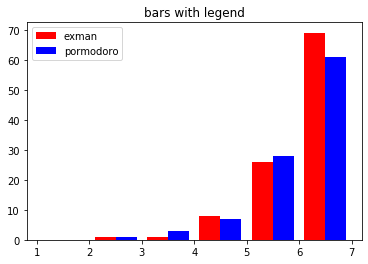

In [37]:
bins = [1,2,3,4,5,6,7]
x = [list(exman_rating["rating"].astype(int)),list(pomodoro_rating["rating"].astype(int))]

label = ["exman","pormodoro"]
colors = ['red', 'blue']
plt.hist(x, bins, histtype='bar', color=colors, label=label)
plt.legend(prop={'size': 10})
plt.title('bars with legend')


plt.show()

In [38]:
from scipy import stats
tStat, pValue = stats.ttest_ind(exman_rating["rating"].astype(int), pomodoro_rating["rating"].astype(int), equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

P-Value:0.3389466734031623 T-Statistic:0.9585245074826414


The p-Value and the t-test is not significant. Therefore, we cannot assume, that exman provides an improvement of the productivity compared to the pomodoro baseline.

<h3> Explaining productivity rating </h3>

Perceived productivity

In [120]:
import statsmodels.api as sm

df_rating = pd.concat([exman_rating, pomodoro_rating])
df_rating['intercept'] = 1

# create dummy variables
version_dummy = pd.get_dummies(df_rating['appVersion'])

df_rating = pd.concat([df_rating, version_dummy], axis=1)


X = df_rating[['intercept', 'brokenFocusPerHour', 'distractionTimePerHour']]
Y = df_rating['rating'].astype(int)

results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     17.13
Date:                Thu, 14 Jan 2021   Prob (F-statistic):           1.34e-07
Time:                        18:40:39   Log-Likelihood:                -291.39
No. Observations:                 205   AIC:                             588.8
Df Residuals:                     202   BIC:                             598.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  5.8291      0.074     78.641      0.000       5.683       5.975
brokenFocusPerHour        -0.0469      0.009     -5.299      0.000      -0.064      -0.029
distractionTimePerHour     0.0365      0.010      3.689      0.000       0.017       0.056
==============================================================================
Omnibus:                       11.803   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.530
Skew:                          -0.604   Prob(JB):                      0.00190
Kurtosis:                       3.079   Cond. No.                         9.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b> -> App version itself is not significant, but distractions and breaking focus are both discouraged in exman <b>

In [40]:
df_rating

X = df_rating[['intercept', 'exman']]
Y = df_rating['goalsAchievedPerHour']

results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     goalsAchievedPerHour   R-squared:                       0.023
Model:                              OLS   Adj. R-squared:                  0.019
Method:                   Least Squares   F-statistic:                     4.874
Date:                  Thu, 14 Jan 2021   Prob (F-statistic):             0.0284
Time:                          16:50:42   Log-Likelihood:                -391.48
No. Observations:                   205   AIC:                             787.0
Df Residuals:                       203   BIC:                             793.6
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4406      0.164      8.776      0.000       1.117       1.764
exman          0.5063      0.229      2.208      0.028       0.054       0.959
==============================================================================
Omnibus:                       65.850   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.569
Skew:                           1.430   Prob(JB):                     3.03e-36
Kurtosis:                       6.312   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b> -> App version is significant in terms of goals achieved per hours (as seen in t-test already) <b>

<h2> General Stats </h2>

In [41]:
pd.concat([
    df[df.PSNR == "p01"]["appVersion"].describe(),
    df[df.PSNR == "p02"]["appVersion"].describe(),
    df[df.PSNR == "p06"]["appVersion"].describe(),
    df[df.PSNR == "p07"]["appVersion"].describe(),
    df[df.PSNR == "p08"]["appVersion"].describe(),
    df[df.PSNR == "p09"]["appVersion"].describe(),
    df[df.PSNR == "p10"]["appVersion"].describe(),
    df[df.PSNR == "p11"]["appVersion"].describe(),
    df[df.PSNR == "p12"]["appVersion"].describe(),
    df[df.PSNR == "p17"]["appVersion"].describe()
],axis=1, keys= df.PSNR.unique())

,p06,p02,p17,p12,p07,p09,p01,p08,p11,p10
count,34,5,12,47,38,27,18,6,24,16
unique,2,2,2,2,2,2,2,2,2,2
top,exman,pomodoro,exman,pomodoro,pomodoro,exman,exman,exman,exman,pomodoro
freq,18,3,7,28,24,15,15,4,14,9


Focus sessions are mostly evenly distributed for pomodoro and exman (except maybe for p01)

<h4> notification per focus per hour </h4>

In [42]:
normalize_data("messages_received_in_focus","minutesInFocus","messagesPerHour",exman)
normalize_data("messages_received_in_focus","minutesInFocus","messagesPerHour",pomodoro)
normalize_data("messages_received_in_focus","minutesInFocus","messagesPerHour",df)

In [43]:
df["messagesPerHour"].describe()

count    227.000000
mean       2.423613
std        5.398558
min        0.000000
25%        0.000000
50%        0.000000
75%        2.400000
max       39.436620
Name: messagesPerHour, dtype: float64

In [44]:
pd.concat([
    df[df.PSNR == "p01"]["messagesPerHour"].describe(),
    df[df.PSNR == "p02"]["messagesPerHour"].describe(),
    df[df.PSNR == "p06"]["messagesPerHour"].describe(),
    df[df.PSNR == "p07"]["messagesPerHour"].describe(),
    df[df.PSNR == "p08"]["messagesPerHour"].describe(),
    df[df.PSNR == "p09"]["messagesPerHour"].describe(),
    df[df.PSNR == "p10"]["messagesPerHour"].describe(),
    df[df.PSNR == "p11"]["messagesPerHour"].describe(),
    df[df.PSNR == "p12"]["messagesPerHour"].describe(),
    df[df.PSNR == "p17"]["messagesPerHour"].describe()
],axis=1, keys= df.PSNR.unique())

,p06,p02,p17,p12,p07,p09,p01,p08,p11,p10
count,34.000000,5.000000,12.000000,47.000000,38.000000,27.000000,18.000000,6.000000,24.000000,16.000000
mean,5.641882,3.296703,2.957682,0.156907,1.336842,3.826513,1.964592,2.750000,3.214057,0.991876
std,8.949720,7.371653,5.005259,0.651255,2.509595,7.779094,4.112791,3.061862,4.769546,1.026662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.584169,0.000000,1.774590,0.000000,0.000000,1.714776,0.000000,2.250000,1.950000,0.778784
75%,7.800000,0.000000,3.110750,0.000000,1.375000,4.000000,2.551268,5.625000,4.200000,2.000000
max,31.200000,16.483516,18.000000,4.012483,9.000000,39.436620,16.800000,6.000000,20.000000,3.000000


<h4> Autoreplies </h4>

In [45]:
exman["autoReplied"].sum()

6

<h4> Broken Focus measurement in minutes </h4>

In [46]:
get_comparison_summary("brokenFocusPerHour")

,pomodoro,exman
count,112.000000,115.000000
mean,3.010914,0.487848
std,10.866147,1.981690
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,59.595000,14.664000


<h4> number of breaks per focus sessions per Hour </h4>

In [47]:
get_comparison_summary("brokenFrequencyPerHour")

,pomodoro,exman
count,112.000000,115.000000
mean,0.502944,0.227479
std,1.589264,0.761047
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,9.077156,4.800000


<h4> Minutes in focus </h4>

In [48]:
df["minutesInFocus"].describe()

count    227.000000
mean      44.588370
std       33.241341
min       10.650000
25%       25.000000
50%       36.410000
75%       54.810000
max      208.520000
Name: minutesInFocus, dtype: float64

In [49]:
pd.concat([
    df[df.PSNR == "p01"]["minutesInFocus"].describe(),
    df[df.PSNR == "p02"]["minutesInFocus"].describe(),
    df[df.PSNR == "p06"]["minutesInFocus"].describe(),
    df[df.PSNR == "p07"]["minutesInFocus"].describe(),
    df[df.PSNR == "p08"]["minutesInFocus"].describe(),
    df[df.PSNR == "p09"]["minutesInFocus"].describe(),
    df[df.PSNR == "p10"]["minutesInFocus"].describe(),
    df[df.PSNR == "p11"]["minutesInFocus"].describe(),
    df[df.PSNR == "p12"]["minutesInFocus"].describe(),
    df[df.PSNR == "p17"]["minutesInFocus"].describe()
],axis=1, keys= df.PSNR.unique())

,p06,p02,p17,p12,p07,p09,p01,p08,p11,p10
count,34.000000,5.000000,12.000000,47.000000,38.000000,27.000000,18.000000,6.000000,24.000000,16.000000
mean,33.787647,94.656000,38.046667,69.852766,31.184211,40.072963,24.534444,37.500000,23.270417,79.236250
std,21.335718,76.930833,8.764239,35.697708,12.650938,33.573583,8.588470,6.123724,8.089137,37.723993
min,15.000000,18.200000,15.000000,17.400000,15.000000,10.650000,15.000000,25.000000,15.000000,30.000000
25%,25.000000,35.240000,40.000000,45.000000,25.000000,22.415000,17.807500,40.000000,15.000000,57.115000
50%,25.000000,82.310000,40.000000,61.760000,25.000000,30.000000,25.000000,40.000000,25.000000,60.000000
75%,40.000000,129.010000,40.000000,91.755000,40.000000,41.045000,25.000000,40.000000,25.000000,110.707500
max,110.910000,208.520000,52.280000,160.000000,60.000000,180.000000,45.000000,40.000000,48.490000,165.000000


<h4> distraction count per participant and per focus session </h4>

In [122]:
pd.concat([
    df[df.PSNR == "p01"]["distractionCount"].describe(),
    #df[df.PSNR == "p02"]["distractionCount"].describe(),
    #df[df.PSNR == "p06"]["distractionCount"].describe(),
    #df[df.PSNR == "p07"]["distractionCount"].describe(),
    df[df.PSNR == "p08"]["distractionCount"].describe(),
    df[df.PSNR == "p09"]["distractionCount"].describe(),
    df[df.PSNR == "p10"]["distractionCount"].describe(),
    df[df.PSNR == "p11"]["distractionCount"].describe(),
    df[df.PSNR == "p12"]["distractionCount"].describe()
    #df[df.PSNR == "p17"]["distractionCount"].describe()
],axis=1, keys= ["1", "8", "9", "10", "11", "12"])

# clear p2,p6,p7 and p17 out of the windowstracking dataframe

,1,8,9,10,11,12
count,34.000000,38.000000,27.000000,18.000000,6.000000,24.000000
mean,0.735294,1.447368,7.629630,2.388889,2.166667,2.541667
std,1.763413,4.886260,11.806609,4.132210,1.471960,6.093326
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.250000,0.000000
50%,0.000000,0.000000,3.000000,0.000000,2.500000,0.000000
75%,0.000000,0.000000,7.500000,2.500000,3.000000,2.000000
max,6.000000,27.000000,44.000000,13.000000,4.000000,26.000000


<h4> 

In [51]:
pd.concat([
    df[df.PSNR == "p01"]["distractionTime"].describe(),
    #df[df.PSNR == "p02"]["distractionTime"].describe(),
    #df[df.PSNR == "p06"]["distractionTime"].describe(),
    #df[df.PSNR == "p07"]["distractionTime"].describe(),
    df[df.PSNR == "p08"]["distractionTime"].describe(),
    df[df.PSNR == "p09"]["distractionTime"].describe(),
    df[df.PSNR == "p10"]["distractionTime"].describe(),
    df[df.PSNR == "p11"]["distractionTime"].describe(),
    df[df.PSNR == "p12"]["distractionTime"].describe(),
    #df[df.PSNR == "p17"]["distractionTime"].describe()
],axis=1, keys= df.PSNR.unique())

# clear p2,p6,p7 and p17 out of the windowstracking dataframe

,p06,p02,p17,p12,p07,p09
count,34.000000,38.000000,27.000000,18.000000,6.000000,24.000000
mean,0.248255,0.742672,4.379106,1.717281,0.401533,0.791240
std,0.738867,2.546034,9.210642,3.724138,0.351710,2.084813
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.031742,0.000000,0.142254,0.000000
50%,0.000000,0.000000,0.465717,0.000000,0.367833,0.000000
75%,0.000000,0.000000,3.976900,1.525800,0.618512,0.125496
max,3.324733,11.209250,35.883900,14.592567,0.904400,7.920617


<h4> Rating </h4>

In [52]:
pd.concat([pomodoro["rating"].dropna().astype(int).describe(),exman["rating"].dropna().astype(int).describe()],axis=1,keys=["pomodoro","exman"])

,pomodoro,exman
count,100.000000,105.000000
mean,5.740000,5.885714
std,1.106637,1.068017
min,2.000000,2.000000
25%,5.000000,5.000000
50%,6.000000,6.000000
75%,7.000000,7.000000
max,7.000000,7.000000


In [70]:
# productivity per version and participants needs to be fixed
pd.concat([
    df[df.PSNR == "p01"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p02"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p06"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p07"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p08"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p09"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p10"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p11"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p12"]["rating"].dropna().astype(int).describe(),
    df[df.PSNR == "p17"]["rating"].dropna().astype(int).describe()
],axis=1, keys= df.PSNR.unique())

,p06,p02,p17,p12,p07,p09,p01,p08,p11,p10
count,30.000000,2.000000,11.000000,45.000000,36.000000,24.000000,17.000000,2.0,22.000000,16.000000
mean,5.600000,6.000000,4.090909,5.022222,6.777778,6.666667,5.823529,7.0,5.909091,5.875000
std,0.855006,1.414214,1.513575,0.722649,0.484686,0.701964,0.727607,0.0,0.610159,1.147461
min,4.000000,5.000000,2.000000,3.000000,5.000000,5.000000,4.000000,7.0,4.000000,4.000000
25%,5.000000,5.500000,3.000000,5.000000,7.000000,7.000000,6.000000,7.0,6.000000,5.000000
50%,6.000000,6.000000,4.000000,5.000000,7.000000,7.000000,6.000000,7.0,6.000000,6.000000
75%,6.000000,6.500000,5.000000,5.000000,7.000000,7.000000,6.000000,7.0,6.000000,7.000000
max,7.000000,7.000000,7.000000,6.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000


P17 has pretty low average productivity rating compared to others. Potential explanations from interview?

In [67]:
# productivity per version and participants needs to be fixed
pd.concat([
    exman_rating[exman_rating.PSNR == "p01"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p02"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p06"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p07"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p08"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p09"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p10"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p11"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p12"]["rating"].dropna().astype(int).describe(),
    exman_rating[exman_rating.PSNR == "p17"]["rating"].dropna().astype(int).describe()
],axis=1, keys= df.PSNR.unique())

,p06,p02,p17,p12,p07,p09,p01,p08,p11,p10
count,17.000000,0.0,6.000000,19.000000,14.0,14.000000,14.000000,1.0,13.000000,7.000000
mean,5.352941,NaN,4.666667,5.000000,7.0,6.857143,5.714286,7.0,5.923077,6.571429
std,0.861770,NaN,1.632993,0.745356,0.0,0.363137,0.726273,NaN,0.493548,1.133893
min,4.000000,NaN,2.000000,3.000000,7.0,6.000000,4.000000,7.0,5.000000,4.000000
25%,5.000000,NaN,4.250000,5.000000,7.0,7.000000,5.250000,7.0,6.000000,7.000000
50%,5.000000,NaN,5.000000,5.000000,7.0,7.000000,6.000000,7.0,6.000000,7.000000
75%,6.000000,NaN,5.000000,5.000000,7.0,7.000000,6.000000,7.0,6.000000,7.000000
max,7.000000,NaN,7.000000,6.000000,7.0,7.000000,7.000000,7.0,7.000000,7.000000


In [69]:
# productivity per version and participants needs to be fixed
pd.concat([
    pomodoro_rating[pomodoro_rating.PSNR == "p01"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p02"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p06"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p07"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p08"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p09"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p10"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p11"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p12"]["rating"].dropna().astype(int).describe(),
    pomodoro_rating[pomodoro_rating.PSNR == "p17"]["rating"].dropna().astype(int).describe()
],axis=1, keys= df.PSNR.unique())

,p06,p02,p17,p12,p07,p09,p01,p08,p11,p10
count,13.000000,2.000000,5.000000,26.000000,22.000000,10.000000,3.000000,1.0,9.000000,9.000000
mean,5.923077,6.000000,3.400000,5.038462,6.636364,6.400000,6.333333,7.0,5.888889,5.333333
std,0.759555,1.414214,1.140175,0.720043,0.581087,0.966092,0.577350,NaN,0.781736,0.866025
min,4.000000,5.000000,2.000000,3.000000,5.000000,5.000000,6.000000,7.0,4.000000,4.000000
25%,6.000000,5.500000,3.000000,5.000000,6.000000,5.500000,6.000000,7.0,6.000000,5.000000
50%,6.000000,6.000000,3.000000,5.000000,7.000000,7.000000,6.000000,7.0,6.000000,5.000000
75%,6.000000,6.500000,4.000000,5.000000,7.000000,7.000000,6.500000,7.0,6.000000,6.000000
max,7.000000,7.000000,5.000000,6.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000
